1. DW KONKURS
2. https://dataworkshop.eu/
3. https://www.kaggle.com/c/carprice/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [313]:
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_squared_error

import scikitplot as skplt

from datetime import datetime

import xgboost as xgb

import lightgbm as lgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


In [225]:
train = pd.read_hdf(r'C:\Users\Seba\Documents\python\datasets-pyth\carprice\train.car_price.h5')
test = pd.read_hdf(r'C:\Users\Seba\Documents\python\datasets-pyth\carprice\test.car_price.h5')

In [4]:
train.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,...,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,...,None,Nowe,II (2012-),None,None,None,Tak,None,None,0
2,"[Osobowe, Peugeot, 3008, Peugeot 3008 I (2009-...","15:48, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT",28000.0,"Tomaszów Mazowiecki, tomaszowski, Łódzkie",None,Osoba prywatna,False,False,...,None,Używane,I (2009-2016),None,None,None,Tak,None,None,2
3,"[Osobowe, Porsche, Cayenne, Porsche Cayenne II...","06:30, 4 marca 2018",PLN,"Cena Netto, Do negocjacji, Faktura VAT",229500.0,"Kępińska 24a - 63-640 Bralin, kępiński, Wielko...",P.W. GRIB,Dealer,True,True,...,None,Używane,II (2010-),None,None,None,None,None,None,3
4,"[Osobowe, Peugeot, 308, Peugeot 308 T7 (2008-2...","08:46, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji",19500.0,"Limanowa, limanowski, Małopolskie",None,Osoba prywatna,False,False,...,None,Używane,T7 (2008-2013),None,None,None,Tak,None,None,4
5,"[Osobowe, Volkswagen, Golf, Volkswagen Golf VI...","20:00, 3 marca 2018",PLN,"Cena Brutto, Faktura VAT",164900.0,"Niciarniana 51/53 - 92-320 Łódź, Śródmieście (...",KROTOSKI-CICHY Niciarniana 51/53 oraz Dąbrowsk...,Dealer,True,True,...,None,Używane,VII (2012-),None,None,None,Tak,None,None,5


In [223]:
train = train.fillna(-1)

# BASIC MODEL

In [293]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.number, np.bool]).columns
    return [feat for feat in feats if feat not in ['price_value','car_id'] ]


def run_cv(model,df, cv=5):
    feats = get_feats(df)
    X = df[feats].values
    y = df['price_value'].values

    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    scores = np.abs(scores)

    skplt.estimators.plot_learning_curve(model, X, y, title='Learning Curve',figsize=(15, 5), cv=cv, scoring='neg_mean_absolute_error')
    return np.mean(scores), np.std(scores)


def run_cv_log(model,df, folds=5):
    feats = get_feats(train)
    X = df[feats].values
    y = df['price_value'].values
    y_log = np.log(y)
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=2018)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y_log[train_idx])
        y_log_pred = model.predict(X[test_idx])
        
        y_pred = np.exp(y_log_pred)
        y_pred[ y_pred < 400 ] = 400 #global minimum
        
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    
    skplt.estimators.plot_learning_curve(model, X, y, title='Learning Curve',figsize=(15, 5), cv=cv, scoring='neg_mean_absolute_error')
    return np.mean(scores), np.std(scores)

(39466.82449995886, 239.47226744300139)

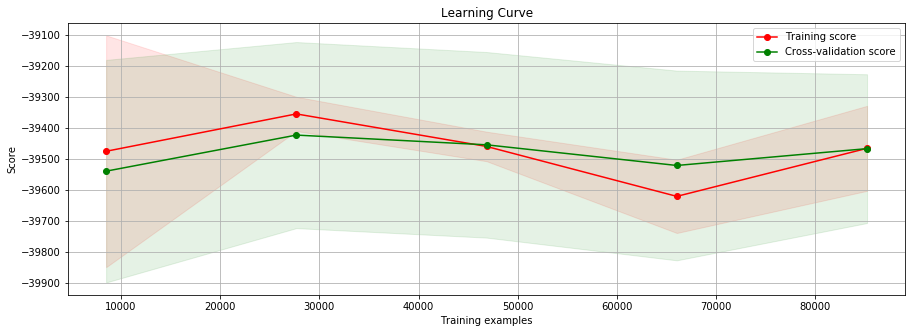

In [8]:
run_cv(DummyRegressor())

[10:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:35:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:36:43] WARNI

(22317.19206519717, 192.93369724969622)

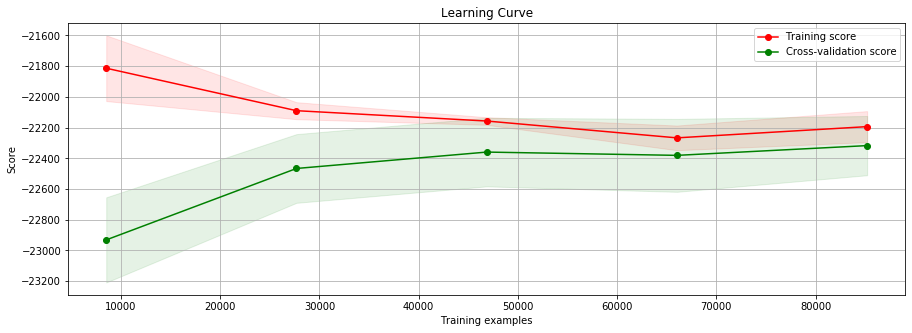

In [301]:
%%time
run_cv(xgb.XGBRegressor(silence=True),train)

Wall time: 47 s


(20662.159997226725, 156.56216611761417)

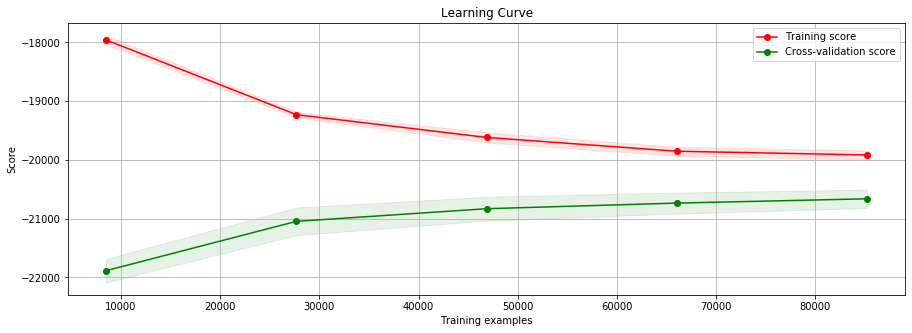

In [169]:
%%time
run_cv(lgb.LGBMRegressor(silent=True),train)

In [302]:
def feature_engineering(df):
    # fill na values
    df_modified = df.fillna(-1)
    
    df_modified['price_currency'] = df_modified['price_currency'].factorize()[0]
    
    #factorize all bolleans
    for x in df.select_dtypes([np.bool]).columns:
        df_modified[x] = df_modified[x].factorize()[0]
    
    # price details to 4 columns
    df_modified['cena brutto'] = df['price_details'].map(lambda x: 1 if 'cena brutto' in x.strip().lower().split(',') or 'brutto' in x.strip().lower().split(',') or 'gross' in x.strip().lower().split(',') else 0)
    df_modified['cena netto'] = df['price_details'].map(lambda x: 1 if 'cena netto' in x.strip().lower().split(',') or 'netto' in x.strip().lower().split(',') else 0)
    df_modified['do_negocjacji'] = df['price_details'].map(lambda x: 1 if 'do negocjacji' in x.strip().lower().split(',') else 0)
    df_modified['faktura_vat'] = df['price_details'].map(lambda x: 1 if 'faktura vat' in x.strip().lower().split(',') else 0) 
    df_modified.drop('price_details',axis=1,inplace=True)
    
    #seller adress
    
    df_modified['seller_type'] = df_modified['seller_type'].apply(lambda x: 'None' if x == -1 else x)
    st_dict = {'Dealer': 0, 
               'Osoba prywatna' : 1,
               'None' : -1}
    df_modified['seller_type'] = df_modified['seller_type'].map(st_dict)
    
    df_modified['uszkodzony'] = df_modified['param_uszkodzony'].apply(lambda x: 1 if x =='Tak' else 0)
    
    df_modified['marka_pojazdu'] = df_modified['param_marka-pojazdu'].factorize()[0]
    
    df_modified['liczba_drzwi'] = df_modified['param_liczba-drzwi'].apply(lambda x: 6 if int(x)>6 else int(x)).factorize()[0]
    
    bins = [0,1000,65000,150000,205000,500000]
    df_modified['przebieg'] = df_modified['param_przebieg'].apply(lambda x: str(x).replace('km','').replace(' ','')).apply(lambda x: int(x))
    df_modified['przebieg'] = df_modified['przebieg'].apply(lambda x: -1 if x>500000 else x)
    df_modified['przebieg'] = pd.factorize( pd.cut(df_modified['przebieg'],bins=bins).astype(object))[0]
    
    df_modified['param_rok-produkcji'] = df_modified['param_rok-produkcji'].factorize()[0]
    
    df_modified['param_napęd'] = df_modified['param_napęd'].apply(lambda x: '4x4' if '4x4' in str(x) else str(x))
    df_modified['param_napęd'] = df_modified['param_napęd'].factorize()[0]
    
    typ = ['Kombi','Sedan','Kompakt','SUV','Auta miejskie','Minivan','Auta małe','Coupe']
    df_modified['param_typ'] = df_modified['param_typ'].apply(lambda x: x if x in typ else 'other')
    df_modified['param_typ'] = df_modified['param_typ'].factorize()[0]
    
    df_modified['param_skrzynia-biegów'] = df_modified['param_skrzynia-biegów'].apply(lambda x: 'Automatyczna/Półautomatyczna' if 'automatyczna' in str(x).lower() else x)
    df_modified['param_skrzynia-biegów'] = df_modified['param_skrzynia-biegów'].factorize()[0]
    
    df_modified['param_oferta-od'] = df_modified['param_oferta-od'].factorize()[0]
    
    df_modified['param_moc'] = df_modified['param_moc'].apply(lambda x: str(x).replace('KM','').replace(' ',''))
    df_modified['param_moc'] = df_modified['param_moc'].apply(lambda x: int(x))
    df_modified['param_moc'] = df_modified['param_moc'].apply(lambda x: -1 if x>800 else x)
    moc = [-1,0,90,122,156,800]
    df_modified['param_moc'] = pd.factorize( pd.cut(df_modified['param_moc'],bins=moc).astype(object))[0]
    
    df_modified['param_kraj-pochodzenia'] = df_modified['param_kraj-pochodzenia'].factorize()[0]
    
    df_modified['param_rodzaj-paliwa'] = df_modified['param_rodzaj-paliwa'].apply(lambda x: 'other' if x not in ['Diesel','Benzyna','Benzyna+LPG'] else x )
    df_modified['param_rodzaj-paliwa'] = df_modified['param_rodzaj-paliwa'].factorize()[0]
    
    df_modified['param_model-pojazdu'] = df_modified['param_model-pojazdu'].factorize()[0]
    
    #df_modified['param_kolor'] = df_modified['param_kolor'].factorize()[0]
    
    df_modified['param_stan'] = df_modified['param_stan'].factorize()[0]
    
    #df_modified['bezwypadkowy'] = df_modified['param_bezwypadkowy'].map(lambda x: 1 if x=='Tak' else 0) 
    
    #df_modified['param_pierwszy-właściciel'] = df_modified['param_pierwszy-właściciel'].factorize()[0]
    
    
    
    #drop useless columns
    df_modified.drop('seller_name',axis=1,inplace=True)
    df_modified.drop('param_uszkodzony',axis=1,inplace=True)
    df_modified.drop('param_marka-pojazdu',axis=1,inplace=True)
    df_modified.drop('param_model',axis=1,inplace=True)
    df_modified.drop('param_engine-code',axis=1,inplace=True)
    df_modified.drop('param_liczba-drzwi',axis=1,inplace=True)
    df_modified.drop('param_first-registration',axis=1,inplace=True)
    df_modified.drop('param_country-of-origin',axis=1,inplace=True)
    df_modified.drop('param_pierwsza-rejestracja',axis=1,inplace=True)
    df_modified.drop('param_gearbox',axis=1,inplace=True)
    df_modified.drop('param_przebieg',axis=1,inplace=True)
    df_modified.drop('param_faktura-vat',axis=1,inplace=True)
    df_modified.drop('param_vin',axis=1,inplace=True)
    df_modified.drop('param_perłowy',axis=1,inplace=True)
    #df_modified.drop('param_homologacja-ciężarowa',axis=1,inplace=True)
    #df_modified.drop('param_przebieg',axis=1,inplace=True)
    #df_modified.drop('param_przebieg',axis=1,inplace=True)
    
    
    
    return df_modified

X_train_mod = feature_engineering(train)

In [86]:
for column in X_train_mod.select_dtypes([np.object]).columns:
    print(column)
    print('')
    print(X_train_mod[column].value_counts(normalize=True))
    print('')

breadcrumb

[Osobowe, Opel, Astra, Opel Astra H (2004-2014)]                   0.013419
[Osobowe, Opel, Insignia, Opel Insignia A (2008-2017)]             0.010949
[Osobowe, Opel, Astra, Opel Astra J (2009-2015)]                   0.009803
[Osobowe, Ford, Focus, Ford Focus Mk3 (2010-)]                     0.008564
[Osobowe, Volkswagen, Passat, Volkswagen Passat B6 (2005-2010)]    0.008517
                                                                     ...   
[Osobowe, Daewoo, MUSSO]                                           0.000009
[Osobowe, BMW, BMW-1M]                                             0.000009
[Osobowe, Lada, 2106]                                              0.000009
[Osobowe, Opel, Inny]                                              0.000009
[Osobowe, Volvo, 340]                                              0.000009
Name: breadcrumb, Length: 2003, dtype: float64

created_at

12:13, 2 marca 2018       0.001230
12:17, 2 marca 2018       0.001127
-1                    

Na przednie koła                 0.619866
-1                               0.154093
Na tylne koła                    0.080831
4x4 (stały)                      0.065318
4x4 (dołączany automatycznie)    0.064567
4x4 (dołączany ręcznie)          0.015325
Name: param_napęd, dtype: float64

param_wartość-wykupu

-1             0.997352
1 PLN          0.000103
1 000 PLN      0.000047
21 000 PLN     0.000028
30 000 PLN     0.000019
                 ...   
150 000 PLN    0.000009
34 140 PLN     0.000009
36 000 PLN     0.000009
341,46 PLN     0.000009
29 952 PLN     0.000009
Name: param_wartość-wykupu, Length: 252, dtype: float64

param_typ

Kombi                   0.205946
Sedan                   0.168789
Kompakt                 0.153004
SUV                     0.151267
Auta miejskie           0.128711
Minivan                 0.123021
Auta małe               0.033420
Coupe                   0.024649
Kabriolet               0.008160
-1                      0.001812
hatchback               0.000

-1     0.999972
Tak    0.000028
Name: param_pearl, dtype: float64

param_stan

Używane    0.910098
Nowe       0.088878
-1         0.001024
Name: param_stan, dtype: float64

param_wersja

-1                  0.225168
II (2012-)          0.014761
H (2004-2014)       0.013409
II (2008-)          0.011390
II (2003 - 2009)    0.011033
                      ...   
B1 (1972-1978)      0.000009
D (1979-1984)       0.000009
I (1985-1993)       0.000009
II (1978-1986)      0.000009
114                 0.000009
Name: param_wersja, Length: 509, dtype: float64

param_emisja-co2

-1          0.980412
4 g/km      0.001840
5 g/km      0.001230
129 g/km    0.000451
119 g/km    0.000451
              ...   
245 g/km    0.000009
203 g/km    0.000009
253 g/km    0.000009
228 g/km    0.000009
75 g/km     0.000009
Name: param_emisja-co2, Length: 188, dtype: float64

param_body-type

-1               0.999221
Sedan            0.000160
Kombi            0.000160
Kompakt          0.000122
Minivan          0.000

Wall time: 1min 2s


(10659.035377063996, 169.47610227890218)

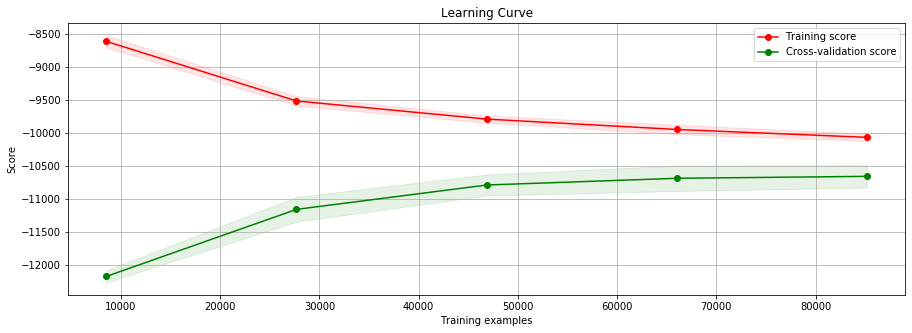

In [323]:
%%time
run_cv(lgb.LGBMRegressor(),X_train_mod)

In [322]:
%%time
def objective(space):
    
    LGBM_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100
    }
    
    feats = get_feats(X_train_mod)
    X = X_train_mod[feats].values
    y = X_train_mod['price_value'].values

    model = lgb.LGBMRegressor(**LGBM_params)
    model.fit(X, y)
    y_pred = model.predict(X)
    
    score = mean_absolute_error(y, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best_params)


100%|█████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.69s/trial, best loss: 9223.325589948186]
The best params:  {'x_colsample_bytree': 0.9021767075752851, 'x_learning_rate': 0.19654987845314614, 'x_max_depth': 8.0, 'x_min_child_weight': 9.0, 'x_random_state': 6200.0, 'x_reg_alpha': 1.4269102434652832, 'x_reg_lambda': 0.8384261261094734, 'x_subsample': 0.8074076818661483}
Wall time: 36.9 s


In [321]:
feats = get_feats(X_train_mod)
X = X_train_mod[feats].values
y = X_train_mod['price_value'].values

model = lgb.LGBMRegressor()
model.fit(X, y)
y_pred = model.predict(X)
    
score = mean_absolute_error(y, y_pred)
print(score)

10204.66231580341
